In [1]:
%matplotlib inline

In [2]:
from scripts.core import *
from pathlib import Path

In [3]:
df=pd.read_csv("/home/sufiyan/data/Daimler/100_vids/csv/20170207_061253_S235_500K_V173015_LW_DML.csv", delimiter=';')

In [4]:
info=["ABA_typ_WorkFlowState OPC_typ_BrakeReq ABA_typ_ABAAudioWarn ABA_typ_SelObj BS_v_EgoFAxleLeft_kmh BS_v_EgoFAxleRight_kmh RDF_val_YawRate RDF_typ_ObjTypeOr RDF_dx_Or RDF_v_RelOr RDF_dy_Or RDF_typ_ObjTypeOs RDF_dx_Os RDF_v_RelOs RDF_dy_Os RDF_typ_ObjTypePed0 RDF_dx_Ped0 RDF_vx_RelPed0 RDF_dy_Ped0 "]
allCols=allCols[0].split()

**allCols** represents the columns from the csv file that we are most interested in.

In [5]:
allCols

['ABA_typ_WorkFlowState',
 'OPC_typ_BrakeReq',
 'ABA_typ_ABAAudioWarn',
 'ABA_typ_SelObj',
 'BS_v_EgoFAxleLeft_kmh',
 'BS_v_EgoFAxleRight_kmh',
 'RDF_val_YawRate',
 'RDF_typ_ObjTypeOr',
 'RDF_dx_Or',
 'RDF_v_RelOr',
 'RDF_dy_Or',
 'RDF_typ_ObjTypeOs',
 'RDF_dx_Os',
 'RDF_v_RelOs',
 'RDF_dy_Os',
 'RDF_typ_ObjTypePed0',
 'RDF_dx_Ped0',
 'RDF_vx_RelPed0',
 'RDF_dy_Ped0']

Plotting all these columns from a file to see how it looks

In [6]:
state=df[allCols[:]]

The below plots can be neglected as they have been segregated according to theis significance in the subsequent plots.

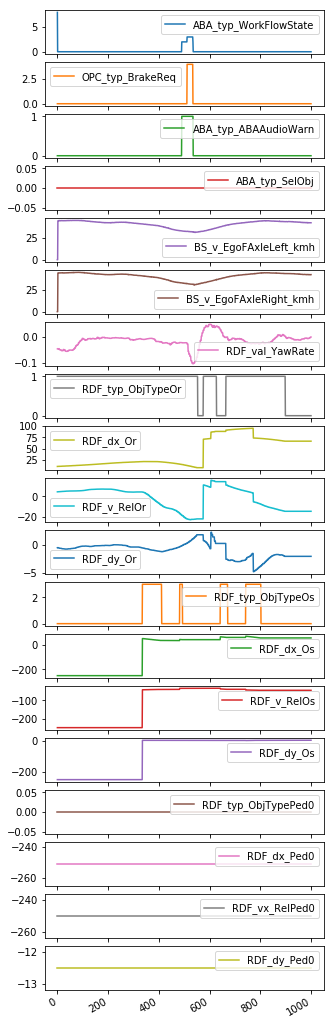

In [7]:
axes=state.plot(subplots=True, figsize=(5,20))

Below line gives the index where the ABA first reacts, somewhere around the middle

In [8]:
df[df["ABA_typ_WorkFlowState"]>0]["ABA_typ_WorkFlowState"].index[1]

490

These classes handle the 4 different groups of columns representing **ABA Reaction, Moving Object, Stationary Object** and **Pedestrian**

They also handle the cleaning and supressing of outliers and noise

In [49]:
class BaseObject:
    def __init__(self,cols, df, supressOutliers=True, supressPostABA=False, **kwargs):
        self.data=df.loc[1:,cols]
        self.kwargs=kwargs
        if 'name' in kwargs: self.name=kwargs['name']
        self.cols=cols
        self.df=df
        self.SupressOutliers(**kwargs)
        if supressPostABA: self.SupressPostABA()
        
    def SupressOutliers(self, outlier_limit=-50, **kwargs):
        #threshold the folating -200 or -250 values to 0 for better resolution in plotting
            #outlier floating value is different for pedestrian.
            #hence outlier limit of -50 does not work for pedestrian.
            #For pedestrians, when there is no detection, the value goes to around -12.5 
            #that needs to be corrected to 0.
        try: outlier_limit=self.kwargs["outlier_limit"]
        except:pass
        for col in self.cols:
            self.data[col]=self.data[col].apply(lambda x: 0 if x< outlier_limit else x)
        return self
        
    def SupressPostABA(self, countBeyondABA=100, **kwargs):
        index=self.df[self.df["ABA_typ_WorkFlowState"]>0]["ABA_typ_WorkFlowState"].index[1]
        self.data=self.data.iloc[:index+countBeyondABA,:]
        return self
        
    def SupressCarryForward(self):
        """Supresses the values when 1st column "RDF_typ_ObjType**" is zero. 
        Then's when the ABA isn't detecting any aboect in it's class but the values as carried forward."""
        for i, row in self.data.iterrows():
            if row[self.data.columns[0]]==0:
                for c,col in enumerate(self.data.columns[1:]): self.data.iloc[i, c+1]=0
        return self
    
    def plot(self, ax=None, **kwargs):
        ax=self.data.plot(ax=ax,subplots=True, title=self.name, **kwargs)
#         ax.legend(bbox_to_anchor=(1.5, 1))
#         ax.set_title(self.name)
        return ax
        
class ABAReaction(BaseObject):
    def __init__(self, df, *args, **kwargs):
        self.cols=["ABA_typ_WorkFlowState", "OPC_typ_BrakeReq", "ABA_typ_ABAAudioWarn", "ABA_typ_SelObj"]
        #Not to supress ABA signals, but supress only CAN signals below
        try: kwargs["supressPostABA"]=False
        except: pass
        super().__init__(self.cols, df, *args, **kwargs, name='ABA_Reaction')    

class MovingObject(BaseObject):
    def __init__(self, df, *args, **kwargs):
        self.cols=["RDF_typ_ObjTypeOr", "RDF_dx_Or", "RDF_v_RelOr", "RDF_dy_Or"]
        super().__init__(self.cols, df, *args, **kwargs, name='MovingObj')

class StationaryObject(BaseObject):
    def __init__(self, df, *args, **kwargs):
        self.cols=["RDF_typ_ObjTypeOs", "RDF_dx_Os", "RDF_v_RelOs", "RDF_dy_Os"]
        super().__init__(self.cols, df, *args, **kwargs, name='StationaryObj')

class PedestrianObject(BaseObject):
    
    def __init__(self, df, *args, **kwargs):
        #anything beyond -5 is floating value for pedestrian (assumption based on plots)
        self.cols=["RDF_typ_ObjTypePed0", "RDF_dx_Ped0", "RDF_vx_RelPed0","RDF_dy_Ped0"]
        super().__init__(self.cols, df, outlier_limit=-5, *args, **kwargs, name='Pedestrain')

Below function plots the dataframe

In [31]:
def print_relevant_object(df):
    ABA_ReactionIndex=df[df["ABA_typ_WorkFlowState"]>0]["ABA_typ_WorkFlowState"].index[1]
    relevantObjectIndex=df["ABA_typ_SelObj"][ABA_ReactionIndex]
    relevantObjects={0:"Driving/Moving Object", 1:"Stationary Object", 2:"Pedestrian A", 3:"Pedestrian B"}
    print("Reason for Braking: ", relevantObjects[relevantObjectIndex])

In [16]:
def plot_df(df, supressPostABA=False):
    df=read_csv_auto(df)
    ABAReaction(df).plot()
    print_relevant_object(df)
    MovingObject(df, supressPostABA=supressPostABA).plot()
    StationaryObject(df, supressPostABA=supressPostABA).plot()
    PedestrianObject(df, supressPostABA=supressPostABA).plot()

This dataframe is plotted before supressing rows beyond ABA reaction. They show that the values in some columns change drastically probably due to noise, but can be eliminated by completely neglecting them after ABA has reacted to an objects proximity. That's why you would see, all the columns after below plot will have values uptill around 600 rather than 1000. Thats because we are considering the values only upto where ABA reacts (very first chart below) + 50 readings.

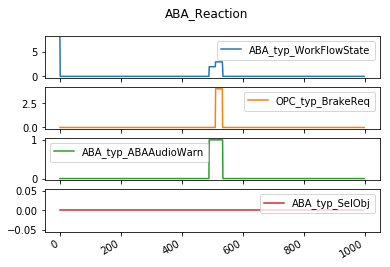

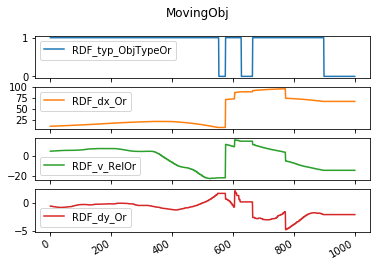

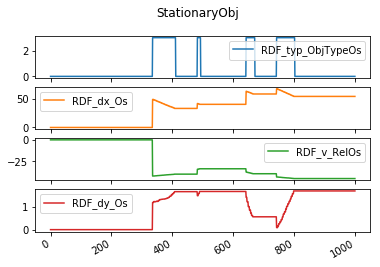

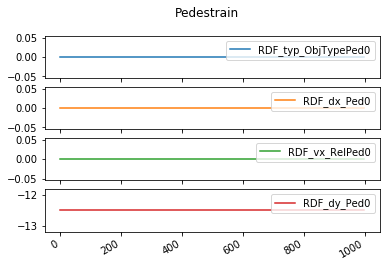

In [38]:
plot_df("/home/sufiyan/data/Daimler/100_vids/csv/20170207_061253_S235_500K_V173015_LW_DML.csv")

Plotting the ***ABA_typ_SelObj*** for all the 100 file to see different type of objects that caused the ABA reaction.
As we can see below, there are 3 videos for signal 2 that represents pedestrian, 1 video that has signal 1 representing stationary object. Apart from these, all the videos are for moving object signal 0.

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


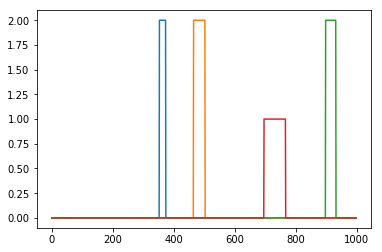

In [47]:
for file in os.listdir("/home/sufiyan/data/Daimler/100_vids/csv/"):
    if file.split(".")[-1]=='csv':
        file="/home/sufiyan/data/Daimler/100_vids/csv/"+file
        try: 
            df=pd.read_csv(file, delimiter=';')
            if not "ABA_typ_SelObj" in df.columns: raise KeyError
        except: df=pd.read_csv(file)
        if not ((df["ABA_typ_SelObj"]==0).all()):
            df["ABA_typ_SelObj"].plot()
        
        

Supressing all the values beyond the ABA reaction to eliminate the noise.
This supression has been added to Base Class above and can be used with *supressPostABA=True*

As we can see in below plots, the Moving Object's curves are smooth and represent tracking of a moving vehicle going leftwards. The noisy values beyond the ABA reaction have been neglected.

Reason for Braking:  Driving/Moving Object


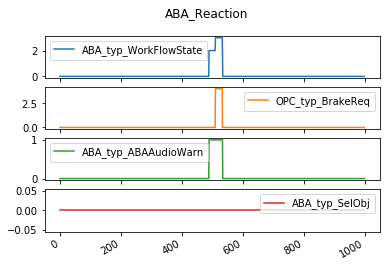

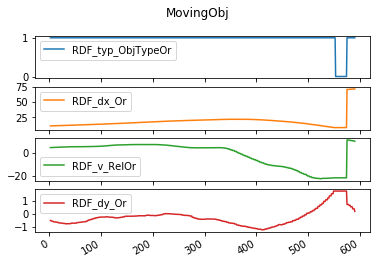

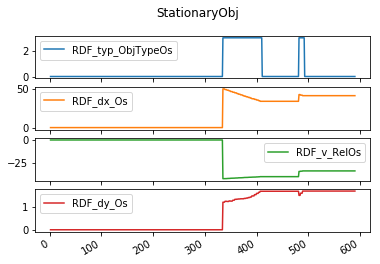

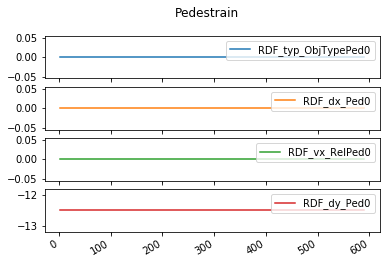

In [13]:
plot_df("/home/sufiyan/data/Daimler/100_vids/csv/20170207_061253_S235_500K_V173015_LW_DML.csv", supressPostABA=True)

Plotting another video where the reason for ABA reaction was a pedestrian crossing. This can be understood from ABA_typ_SelObj value of 3 (4th plot in ABA_reaction). We can see in Pedestrian plots below how its position RDF_y_ped0 moves to -ve representing that he crosses the road left to right. 

RDF_y_XXXXX represent the object XXXXX 's position in horiontal direction. +ve values are left from center and -ve towards right. Value changing +vs to -ve represents the object moving left to right.

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Reason for Braking:  Pedestrian A


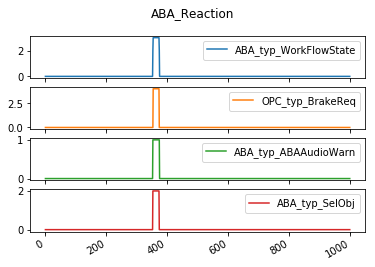

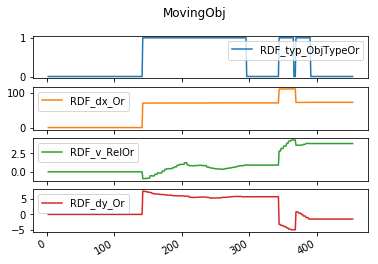

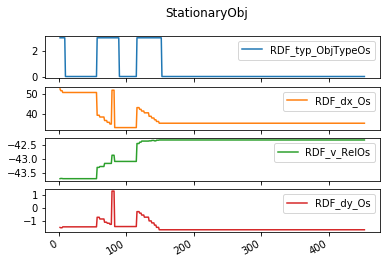

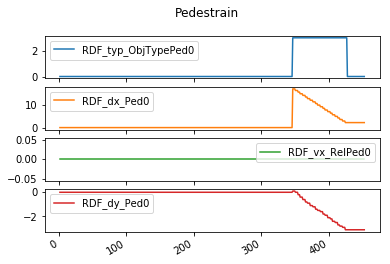

In [20]:
plot_df("/home/sufiyan/data/Daimler/100_vids/csv/20170211_043609_S235_500K_V173015_LW_DML.csv", supressPostABA=True)

In [24]:
files=["/home/sufiyan/data/Daimler/100_vids/csv/"+file for file in os.listdir("/home/sufiyan/data/Daimler/100_vids/csv") if file.split(".")[-1]=='csv']

Below, I plot the StationaryObj twice, once with a pulldown and once without. We can see that without the pulldown (by supressCarryForward() method), the values float high (analogous to a floating pin in microcontroler) even when there is no detection.

supressPostABA argument neglects the values beyond ABA reaction+50 reading. The supressCarryForward() method gives pull down effect.

Reason for Braking:  Driving/Moving Object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1527688748>,
      dtype=object)

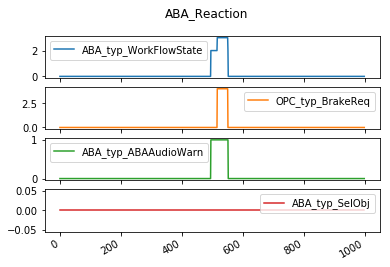

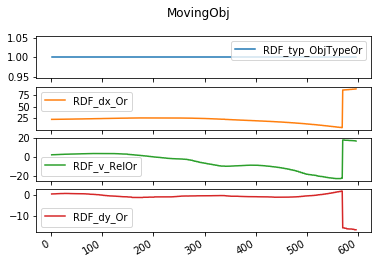

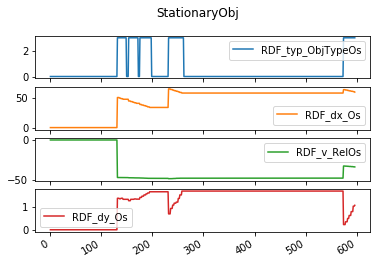

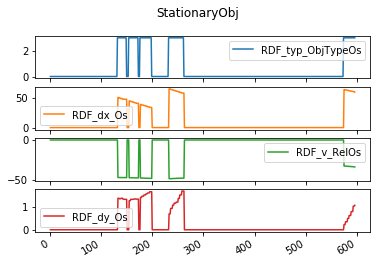

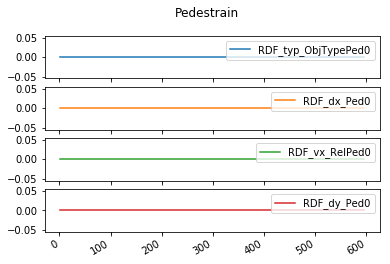

In [55]:
df=files[5]
df=read_csv_auto(df)
supressPostABA=True
abaObj=ABAReaction(df)
abaObj.plot()
print_relevant_object(df)
mvObj=MovingObject(df, supressPostABA=supressPostABA); mvObj.plot()
stObj=StationaryObject(df, supressPostABA=supressPostABA); stObj.plot()  #normal plotting
StationaryObject(df, supressPostABA=supressPostABA).SupressCarryForward().plot() #supressing floating values
pedObj=PedestrianObject(df, supressPostABA=supressPostABA); pedObj.plot()

#### Edge Detection with Laplacian Operator
Idea borrwed form Digital Image Processing, Laplace $\frac{\partial^2 V}{\partial x^2}$ in 1 dimention can be used to calculate sudden change in values and threshold the Laplacian values to detect different sections of the signal and supress the  noise. This might be useful in some way to detect the noisy section, But has not been used in the above code yet.

In [63]:
from scipy.ndimage.filters import laplace

In [77]:
ar=np.asarray(list(MovingObject(df, supressPostABA=False).data.RDF_dy_Or))

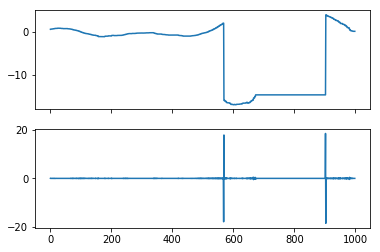

In [79]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(ar)
ax2.plot(laplace(ar))